In [1]:
from typing import List, Tuple, Dict, Literal
from pathlib import Path
import pickle
from pprint import pprint
import sys
sys.path.append('..')

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
import yaml

from scripts import data

In [2]:
DIR_INPUTS = Path('../../data/inputs')
dir_path = Path.joinpath(DIR_INPUTS, 'csv_files')
DIR_PATH_CONFIGS = Path('../../data/configs/paths.yaml')
COLUMNS_BASE = [
    'case_id',
    'date_decision',
    'MONTH',
    'WEEK_NUM',
    'target',
]
COLUMNS_BASE_TEST = [
    'case_id',
    'date_decision',
    'MONTH',
    'WEEK_NUM',
]

with open(DIR_PATH_CONFIGS, 'r') as f:
    dict_tables_all = yaml.safe_load(f)

pprint(dict_tables_all)

{0: {'static': ['static_0_0.csv', 'static_0_1.csv'],
     'static_cb': ['static_cb_0.csv']},
 1: {'applprev': ['applprev_1_0.csv', 'applprev_1_1.csv'],
     'credit_bureau_a': ['credit_bureau_a_1_0.csv',
                         'credit_bureau_a_1_1.csv',
                         'credit_bureau_a_1_2.csv',
                         'credit_bureau_a_1_3.csv'],
     'credit_bureau_b': ['credit_bureau_b_1.csv'],
     'debitcard': ['debitcard_1.csv'],
     'deposit': ['deposit_1.csv'],
     'other': ['other_1.csv'],
     'person': ['person_1.csv'],
     'tax_registry_a': ['tax_registry_a_1.csv'],
     'tax_registry_b': ['tax_registry_b_1.csv'],
     'tax_registry_c': ['tax_registry_c_1.csv']},
 2: {'applprev': ['applprev_2.csv'],
     'credit_bureau_a': ['credit_bureau_a_2_0.csv',
                         'credit_bureau_a_2_1.csv',
                         'credit_bureau_a_2_2.csv',
                         'credit_bureau_a_2_3.csv',
                         'credit_bureau_a_2_4.csv',
     

In [3]:
dict_tabels_use = {
    0: list(dict_tables_all[0].keys()),
    1: list(dict_tables_all[1].keys()),
    2: [],
}
category_columns_use = ['P', 'M', 'A', 'D']

pprint(dict_tabels_use)

{0: ['static', 'static_cb'],
 1: ['applprev',
     'credit_bureau_a',
     'credit_bureau_b',
     'debitcard',
     'deposit',
     'other',
     'person',
     'tax_registry_a',
     'tax_registry_b',
     'tax_registry_c'],
 2: []}


In [4]:
df_train_merger = data.DataFrameMerger(dict_tables_all, dict_tabels_use, category_columns_use, dir_path)
df_base_train, dict_df_train = df_train_merger.load_concat('train')
dict_df_train = df_train_merger.aggregate(dict_df_train)
df_train = df_train_merger.merge(df_base_train, dict_df_train)

base (1526659, 5)


/Users/suzukiyuto/kaggle-works/home-credit-competition/src/notebooks/../scripts/data.py:80: DtypeWarning: Columns (20,45,46,53,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ = pd.read_csv(Path.joinpath(self.dir_path, mode, f'{mode}_{p}'))
/Users/suzukiyuto/kaggle-works/home-credit-competition/src/notebooks/../scripts/data.py:80: DtypeWarning: Columns (20,45,46,56,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ = pd.read_csv(Path.joinpath(self.dir_path, mode, f'{mode}_{p}'))


static (1526659, 77)


/Users/suzukiyuto/kaggle-works/home-credit-competition/src/notebooks/../scripts/data.py:80: DtypeWarning: Columns (1,2,3,4,7,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ = pd.read_csv(Path.joinpath(self.dir_path, mode, f'{mode}_{p}'))


static_cb (1500476, 19)


/Users/suzukiyuto/kaggle-works/home-credit-competition/src/notebooks/../scripts/data.py:80: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ = pd.read_csv(Path.joinpath(self.dir_path, mode, f'{mode}_{p}'))
/Users/suzukiyuto/kaggle-works/home-credit-competition/src/notebooks/../scripts/data.py:80: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ = pd.read_csv(Path.joinpath(self.dir_path, mode, f'{mode}_{p}'))


applprev (1221522, 28)


/Users/suzukiyuto/kaggle-works/home-credit-competition/src/notebooks/../scripts/data.py:80: DtypeWarning: Columns (11,12,14,30,44,54) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ = pd.read_csv(Path.joinpath(self.dir_path, mode, f'{mode}_{p}'))


credit_bureau_a (1386273, 50)


/Users/suzukiyuto/kaggle-works/home-credit-competition/src/notebooks/../scripts/data.py:80: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ = pd.read_csv(Path.joinpath(self.dir_path, mode, f'{mode}_{p}'))


credit_bureau_b (36500, 33)
debitcard (111772, 5)
deposit (105111, 4)
other (51109, 6)


/Users/suzukiyuto/kaggle-works/home-credit-competition/src/notebooks/../scripts/data.py:80: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ = pd.read_csv(Path.joinpath(self.dir_path, mode, f'{mode}_{p}'))


person (1526659, 13)
tax_registry_a (457934, 4)
tax_registry_b (150732, 4)
tax_registry_c (482265, 4)
Aggregate by case_id for tables with depth=1, 2
NOT IMPLEMENTED YET


In [5]:
df_train

,case_id,date_decision,MONTH,WEEK_NUM,target,actualdpdtolerance_344P,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,...,empl_employedfrom_271D,name_4527232M,amount_4527230A,recorddate_4527225D,name_4917606M,amount_4917619A,deductiondate_4917603D,employername_160M,pmtamount_36A,processingdate_168D
0,0,2019-01-03,201901,0,0,NaN,NaN,NaN,NaN,NaN,...,2017-09-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2019-01-03,201901,0,0,NaN,NaN,NaN,NaN,NaN,...,2008-10-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2019-01-04,201901,0,0,NaN,NaN,NaN,NaN,NaN,...,2010-02-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2019-01-03,201901,0,0,NaN,NaN,NaN,NaN,NaN,...,2018-05-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2019-01-04,201901,0,1,NaN,NaN,NaN,NaN,NaN,...,2014-12-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,2703450,2020-10-05,202010,91,0,0.0,-23.0,-43.0,-23.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1526655,2703451,2020-10-05,202010,91,0,0.0,-18.0,-12.0,-18.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1526656,2703452,2020-10-05,202010,91,0,0.0,-12.0,NaN,-16.0,1.0,...,NaN,NaN,NaN,NaN,5502675a,6033.6,2020-05-05,NaN,NaN,NaN
1526657,2703453,2020-10-05,202010,91,0,0.0,-33.0,-64.0,-34.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_train_processed = data.preprocess(df_train, category_columns_use, mode='train')
y = df_train_processed[COLUMNS_BASE]
X = df_train_processed.drop(columns=COLUMNS_BASE)

In [7]:
display(X)
display(X.dtypes)
display(y)

,actualdpdtolerance_344P,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avgmaxdpdlast9m_3716943P,maxdbddpdlast1m_3658939P,maxdbddpdtollast12m_3658940P,maxdbddpdtollast6m_4187119P,maxdpdfrom6mto36m_3546853P,...,recorddate_4527225D_day,recorddate_4527225D_weekday,deductiondate_4917603D_year,deductiondate_4917603D_month,deductiondate_4917603D_day,deductiondate_4917603D_weekday,processingdate_168D_year,processingdate_168D_month,processingdate_168D_day,processingdate_168D_weekday
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,0.0,-23.0,-43.0,-23.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1526655,0.0,-18.0,-12.0,-18.0,0.0,0.0,0.0,2.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1526656,0.0,-12.0,NaN,-16.0,1.0,NaN,NaN,-27.0,NaN,4.0,...,NaN,NaN,2020.0,5.0,5.0,1.0,NaN,NaN,NaN,NaN
1526657,0.0,-33.0,-64.0,-34.0,0.0,0.0,-66.0,0.0,-33.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


actualdpdtolerance_344P           float64
avgdbddpdlast24m_3658932P         float64
avgdbddpdlast3m_4187120P          float64
avgdbdtollast24m_4525197P         float64
avgdpdtolclosure24_3658938P       float64
                                   ...   
deductiondate_4917603D_weekday    float64
processingdate_168D_year          float64
processingdate_168D_month         float64
processingdate_168D_day           float64
processingdate_168D_weekday       float64
Length: 400, dtype: object

,case_id,date_decision,MONTH,WEEK_NUM,target
0,0,2019-01-03,201901,0,0
1,1,2019-01-03,201901,0,0
2,2,2019-01-04,201901,0,0
3,3,2019-01-03,201901,0,0
4,4,2019-01-04,201901,0,1
...,...,...,...,...,...
1526654,2703450,2020-10-05,202010,91,0
1526655,2703451,2020-10-05,202010,91,0
1526656,2703452,2020-10-05,202010,91,0
1526657,2703453,2020-10-05,202010,91,0


In [8]:
X.to_parquet('../../data/models/d01-PMAD-lgbm-cv/X.parquet')
y.to_parquet('../../data/models/d01-PMAD-lgbm-cv/y.parquet')

In [9]:
# cols = X.columns
# for cat in ['P', 'M', 'A', 'year', 'month', 'day', 'weekday']:
#     cols_ = [col for col in cols if col.endswith(cat)]
#     print(cat)
#     display(X[cols_].dtypes)

In [10]:
X = pd.read_parquet('../../data/models/d01-PMAD-lgbm-cv/X.parquet')
y = pd.read_parquet('../../data/models/d01-PMAD-lgbm-cv/y.parquet')

In [11]:
print(X.shape, y.shape)
# X = X[:len(X)//20]
# y = y[:len(y)//20]
print(X.shape, y.shape)

(1526659, 400) (1526659, 5)
(1526659, 400) (1526659, 5)


In [12]:
params = {
    'objective': 'binary',
    'metric': ['binary_logoss', 'auc', 'average_precision'],
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'seed': 42,
    'max_depth': 5,
    'num_leaves': 31,
}

In [13]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
models = []
y_preds_valid = []
idx_valid = []
for n, (train_index, valid_index) in enumerate(skf.split(X, y['target'])):
    print(f'Fold {n+1}')
    dataset_train = lgb.Dataset(X.iloc[train_index], y.iloc[train_index]['target'])
    dataset_valid = lgb.Dataset(X.iloc[valid_index], y.iloc[valid_index]['target'])
    print(f'Train: {len(train_index)}, Valid: {len(valid_index)}')
    
    model = lgb.train(
        params,
        dataset_train,
        num_boost_round=100_000,
        valid_sets=[dataset_train, dataset_valid],
        callbacks=[
            lgb.early_stopping(100, first_metric_only=True),
            lgb.log_evaluation(100),
        ],
    )
    models.append(model)
    y_pred_valid = model.predict(X.iloc[valid_index])
    y_preds_valid.append(y_pred_valid)
    idx_valid.append(valid_index)

y_preds_valid = np.concatenate(y_preds_valid)
idx_valid = np.concatenate(idx_valid)

Fold 1
Train: 1221327, Valid: 305332
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.839225	training's average_precision: 0.189053	valid_1's auc: 0.819803	valid_1's average_precision: 0.150489
[200]	training's auc: 0.854994	training's average_precision: 0.222488	valid_1's auc: 0.825475	valid_1's average_precision: 0.155638
[300]	training's auc: 0.866221	training's average_precision: 0.254409	valid_1's auc: 0.827974	valid_1's average_precision: 0.158297
[400]	training's auc: 0.87548	training's average_precision: 0.283731	valid_1's auc: 0.828869	valid_1's average_precision: 0.159502
[500]	training's auc: 0.883195	training's average_precision: 0.31141	valid_1's auc: 0.829682	valid_1's average_precision: 0.160883
[600]	training's auc: 0.890353	training's average_precision: 0.339812	valid_1's auc: 0.829648	valid_1's average_precision: 0.160942
[700]	training's auc: 0.896415	training's average_precision: 0.366293	valid_1's auc: 0.830016	valid_1's average

In [15]:
# save models
save_dir = Path('../../data/models/d01-PMAD-lgbm-cv')
if not save_dir.exists():
    save_dir.mkdir(parents=True)
    print(f'Create {save_dir}')
for i, model in enumerate(models):
    with open(Path.joinpath(save_dir, f'model_{i}.pkl'), 'wb') as f:
        pickle.dump(model, f)

# save y_preds_valid
np.save(Path.joinpath(save_dir, 'y_preds_valid.npy'), y_preds_valid)
np.save(Path.joinpath(save_dir, 'idx_valid.npy'), idx_valid)

## evaluation (out of fold)

(1526659, 5) (1526659,)


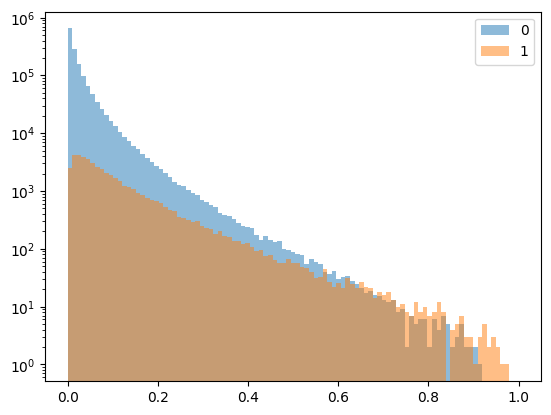

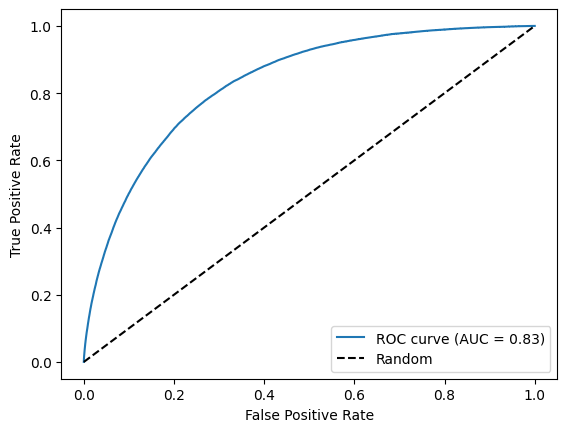

0.6360416163651087


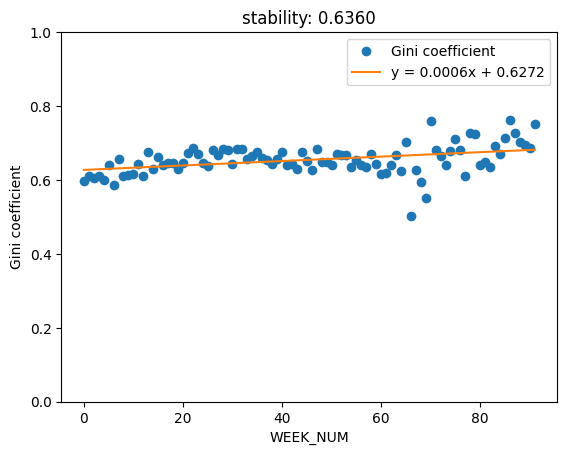

In [20]:
evaluator = data.Evaluator(y.iloc[idx_valid], y_preds_valid, save_path=save_dir)

evaluator.plot_pred(is_log=True)
evaluator.plot_roc()
df_gini_weeks, stability = evaluator.plot_gini()

## evaluation (test dataset) and submission

In [39]:
df_base_test, dict_df_test = df_train_merger.load_concat('test')
dict_df_test = df_train_merger.aggregate(dict_df_test)
df_test = df_train_merger.merge(df_base_test, dict_df_test)

df_test_processed = preprocess(df_test, category_columns_use, mode='test')
X_test = df_test_processed.drop(columns=COLUMNS_BASE_TEST)

base (10, 4)
static (20, 168)
static_cb (10, 53)
Aggregate by case_id for tables with depth=1, 2
NOT IMPLEMENTED YET


In [42]:
y_pred_test_folds = get_y_pred_folds(models, X_test)
y_pred_test = np.mean(y_pred_test_folds, axis=0)

df_submission = pd.DataFrame({
    'case_id': df_test['case_id'],
    'score': y_pred_test,
})

df_submission.to_csv('../../data/outputs/submission.csv', index=False)

In [43]:
df_submission

,case_id,score
0,57543,0.053082
1,57549,0.063964
2,57551,0.045013
3,57552,0.029106
4,57569,0.007297
5,57630,0.022945
6,57631,0.006501
7,57632,0.004456
8,57633,0.049782
9,57634,0.052734
